$~$

# IT Academy - Data Science Itinerary



$~$

## S10 T01: Supervised Classification
___


In [179]:
#importing libraries


import pandas as pd
import numpy as np
from numpy import inf
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import kaggle  

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, MinMaxScaler,RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import svm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline  


import warnings
warnings.filterwarnings("ignore")

sns.set_context("talk")
plt.style.use('ggplot')


$~$ 

#### Downloanding the dataset:
___
$~$ 


$~$

As we do before we are going to download [dataset](https://www.kaggle.com/datasets/giovamata/airlinedelaycauses) from Kaggle and pre processing it.

$~$

dataset is composd by the following variables:


   1. **Year** = 2008
   2. **Month** = 1-12
   3. **DayofMonth** = 1-31
   4.	**DayOfWeek** = 1 (Monday) - 7 (Sunday)
   5.	**DepTime** = actual departure time (local, hhmm)
   6.	**CRSDepTime** = scheduled departure time (local, hhmm)
   7.	**ArrTime** = actual arrival time (local, hhmm)
   8.	**CRSArrTime** = scheduled arrival time (local, hhmm)
   9.	**UniqueCarrier** = unique carrier code
   10.	**FlightNum** = flight number
   11.	**TailNum** = plane tail number: aircraft registration, unique aircraft identifier
   12.	**ActualElapsedTime** = in minutes
   13.	**CRSElapsedTime** = in minutes
   14.	**AirTime** = in minutes
   15.	**ArrDelay** = arrival delay, in minutes: A flight is counted as "on time" if it operated less than 15 minutes later the scheduled time shown in the carriers' Computerized Reservations Systems (CRS).
   16.	**DepDelay** = departure delay, in minutes
   17.	**Origin** = origin IATA airport code
   18.	**Dest** = destination IATA airport code
   19.	**Distance** = in miles
   20.	**TaxiIn** = taxi in time, in minutes
   21.	**TaxiOut** = taxi out time in minutes
   22.	**Cancelled** = *was the flight cancelled
   23.	**CancellationCode** = reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
   24.	**Diverted** = 1 = yes, 0 = no
   25.	**CarrierDelay** = in minutes: Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
   26.	**WeatherDelay** = in minutes: Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.
   27.	**NASDelay**  = in minutes: Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc.
   28.	**SecurityDelay** = in minutes: Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
   29.	**LateAircraftDelay** = in minutes: Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.


$~$

*before executing the next cell, you will need to have previously downloaded the Kaggle API credentials. In case you don't have it, you can follow this [tutorial](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) to get the credentials.*

$~$


In [180]:
PATH = "./data"
#downloanding the data set:
if not os.path.exists(PATH):
    os.makedirs(PATH)
if not os.listdir(PATH):
    !kaggle datasets download -d "giovamata/airlinedelaycauses" --unzip  -p $PATH  

# # check the files:
files = [os.path.join(PATH, f) for f in os.listdir(PATH)]
for f in files:
    print(f)

./data/st99_d00.shp
./data/st99_d00.shx
./data/st99_d00.dbf
./data/DelayedFlights.csv


In [181]:
# load the dataset into a pandas dataframe:
df = pd.read_csv(files[3], index_col=[0])

In [182]:
df.shape

(1936758, 29)

$~$

#### Data preprocessing:
___
$~$

We will process the data following the following steps:

1. Since we already know what each of the variables represents, we can say that a flight that does not have information about its arrival time is not useful to us (without arrival time we do not know if a flight arrived on time or not)

2. The next thing will be to give each variable its type (categorical variables, variables that represent dates, etc.

3. The canceled or diverted flights, for this exercise, are not useful to us. For this, we will remove them. We are also going to remove the columns that imply information about whether a flight is canceled or not.

4. We will create a new binomial variable "with delay" where 1 represents if a flight is delayed and o represents that it arrived on time.

5. we will remove flights that cannot be identified (i.e. values ​​that do not have Tail_Num values)

6. We will show that there are null values ​​in the dataset and that they are in the flights that arrived on time. When a flight arrives on time there are no values ​​for the columns that collect the causes of the delay. For this reason, to avoid having null values ​​we are going to impute 0 in these values

7. We know that "Arrival Delay" is also the sum of CarrierDelay, WeatherDelay, NASdelay amd LateAirCrafDelay. These variables are included in "Arrival Delay" so we can keep only this one.

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936758 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

In [184]:
# wihtout arrival time is imposible to know if a flight arrived on time or not
df.dropna(subset=["ArrTime"],inplace=True)

In [185]:
## changing types:
df[['DepTime','ArrTime']] = df[['DepTime','ArrTime']].astype(int)

#to_change changing type from "objet" to "category"
to_change = ["Month", "DayofMonth", "DayOfWeek","FlightNum", "Origin",
             "Dest", "TailNum", "UniqueCarrier","CancellationCode","Cancelled","Diverted"]

for x in to_change:
    df[x] = df[x].astype("category")

to_date = ["CRSArrTime", "CRSDepTime","DepTime","ArrTime"]

#to_date changing type to date

for x in to_date:
    df[x]= df[x].astype(str).str.zfill(4)
    df[x]= df[x].astype(str).str[:2] +':'+ df[x].astype(str).str[2:] +':00'
    df.loc[df[x]=="24:00:00",x] = "00:00:00" 
    df[x] = pd.to_datetime(df[x], format="%H:%M:%S").dt.time
  


In [186]:
# keep values cancelled ==1 (flights cancelled) in a diferent dataframe.
df_cancelled = df.loc[df['Cancelled'] == 1]
# keep values diverted ==1 (flights diverted) in a diferent dataframe.
df_diverted = df.loc[df['Diverted'] == 1]

# New dataframe with out cancelled and diverted values
df_analisys = df.loc[(df['Cancelled'] == 0) & (df['Diverted'] ==0)].copy()
#clean memory
del df

In [187]:
# As we aren't going to use it, we can drop "Cacelled","CancellationCode","Diverted","Year" columns from our new dataframe
df_analisys.drop(columns=["Cancelled", "CancellationCode","Diverted","Year"], inplace=True)

$~$

For this exercise, we will consider the values equal to or less than zero in "ArrDelay" as an indicate for those flights arrived on time:

+   0 = on time
+   1 = with delay

$~$

In [188]:
#where on time or delay new column
# where delayed = 1 
# and on time = 0

df_analisys['with_delay'] = np.where(df_analisys['ArrDelay'] > 0, 1, 0)
df_analisys['with_delay'] = df_analisys['with_delay'].astype("category")

In [189]:
#check for null values in our new dataframe
df_analisys.isnull().sum()

Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                   0
CRSDepTime                0
ArrTime                   0
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum                   3
ActualElapsedTime         0
CRSElapsedTime            0
AirTime                   0
ArrDelay                  0
DepDelay                  0
Origin                    0
Dest                      0
Distance                  0
TaxiIn                    0
TaxiOut                   0
CarrierDelay         680883
WeatherDelay         680883
NASDelay             680883
SecurityDelay        680883
LateAircraftDelay    680883
with_delay                0
dtype: int64

In [190]:
# wihtout TailNum (aircraft registration) is imposible to know which flight arrived on time or not
df_analisys.dropna(subset=["TailNum"],inplace=True)

In [191]:
#null values come from flight on time (for our dataset arrDelay <15 means) makes sense, 
#if a flight arrives on time there will be not information about the causes of the delays
df_analisys[df_analisys['ArrDelay'] <15].isnull().sum()

Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                   0
CRSDepTime                0
ArrTime                   0
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum                   0
ActualElapsedTime         0
CRSElapsedTime            0
AirTime                   0
ArrDelay                  0
DepDelay                  0
Origin                    0
Dest                      0
Distance                  0
TaxiIn                    0
TaxiOut                   0
CarrierDelay         680882
WeatherDelay         680882
NASDelay             680882
SecurityDelay        680882
LateAircraftDelay    680882
with_delay                0
dtype: int64

In [192]:
#imputing 0 to Nan Values
df_analisys.replace(np.nan,0, inplace=True)



$~$

note that when **"Arrival Delay"** is longer than 15 minutes there's data about what caused the delay. Arrival Delay is the sum of CarrierDelay, WeatherDelay, NASDelay and LateAircraftDelay. So, since one of the variables already picks up the effect of the others, we can eliminate : CarrierDelay, WeatherDelay, NASDelay and LateAircraftDelay.

$~$

In [193]:

# copy variables which described caused of the delay into a diferent dataframe to evaluate multicollinearity
df_cause_delay = df_analisys[[
    "CarrierDelay", "WeatherDelay", "NASDelay", "LateAircraftDelay"]].copy()

# drop non necessary variables from our df_analisys dataframe
df_analisys.drop(columns=["CarrierDelay", "WeatherDelay",
                 "NASDelay", "LateAircraftDelay"], inplace=True)


$~$

+ As our target variable is "with_delay" it also makes no sense to leave the variable "Security Delay" as it only has values when there is a delay. So, we are able to drop this variable too

$~$

In [194]:
df_analisys.drop(columns=["SecurityDelay"], inplace=True)


In [195]:
# drop duplicates
df_analisys.drop_duplicates(inplace=True)

$~$

#### Dependent Variable:


$~$


In [196]:
# dependent variable 
y = df_analisys[["with_delay"]]

In [197]:
#show proportion between  clasess

y.value_counts(normalize=True)

with_delay
1             0.893715
0             0.106285
dtype: float64

In [198]:
#fuction to show percentage in fig:

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

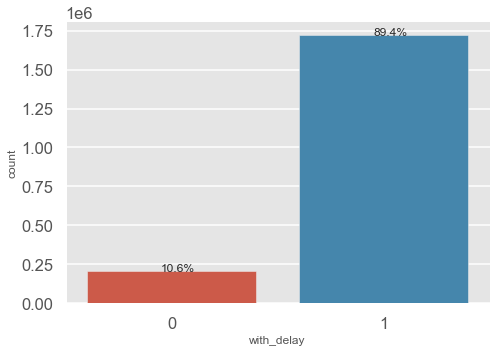

In [199]:
#plot dependent variable proportion:

sns.set_context("talk")
plt.style.use('ggplot')

# where 0 = delayed & 1 = on time
plt.figure(figsize=(7,5))
ax = sns.countplot(x="with_delay",data=y)

without_hue(ax, y)

plt.tight_layout()
plt.show()

$~$

*From what can be seen in the previous graph, we have unbalanced classes, this is something that we have to take into account when we make our models.*

$~$


$~$ 

#### Independent variables:

$~$ 


In [200]:

# # independent variables
X = df_analisys.drop(["ArrDelay", "with_delay"], axis=1)

$~$ 

+ numerical features:

$~$ 


In [201]:
#filter numerical variables

X_num= X.select_dtypes(include=["int64","float64"])

$~$ 

+ Testing Multicollinearity:

$~$ 


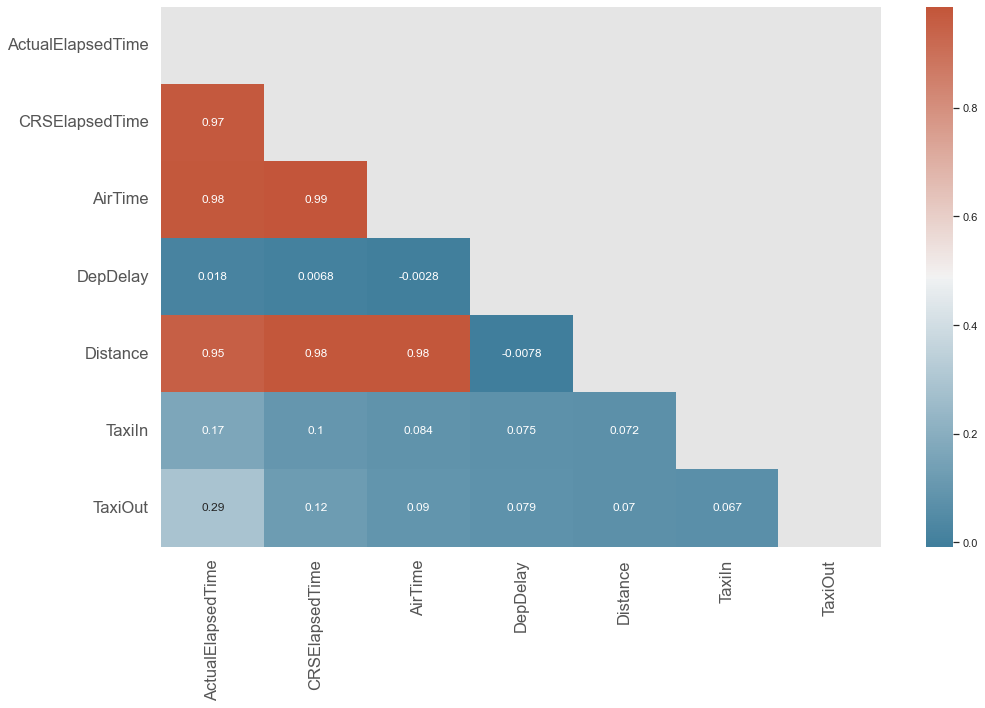

In [202]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(15, 10))
corr = X_num.corr()
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap)

plt.tight_layout()
plt.show()


$~$

for what the matrix of correlations shows there are correlation between "Airtime", "ActualElapsedTime", "CRSElapsedTime"

$~$


In [203]:
# calculated the VIF for variables in X_num:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(
    X_num.values, i) for i in range(X_num.shape[1])]
vif['variable'] = X_num.columns
vif.sort_values(by="VIF")


,VIF,variable
3,1.645477,DepDelay
4,66.554900,Distance
1,126.959898,CRSElapsedTime
0,inf,ActualElapsedTime
2,inf,AirTime
5,inf,TaxiIn
6,inf,TaxiOut


In [204]:
# keep non necessary variables in diferent dataframe X_drop_vif
X_drop_vif = X_num[["ActualElapsedTime","AirTime","CRSElapsedTime"]].copy()

X_num.drop(["ActualElapsedTime","AirTime","CRSElapsedTime"],axis=1,inplace=True)

$~$

let's try again  Multicollinearity after drop "ActualElapsedTime","AirTime","CRSElapsedTime"

$~$

In [205]:
# calculated the VIF for variables in X_num:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(
    X_num.values, i) for i in range(X_num.shape[1])]
vif['variable'] = X_num.columns
vif.sort_values(by="VIF")


,VIF,variable
0,1.553401,DepDelay
1,2.140146,Distance
3,2.151741,TaxiOut
2,2.172104,TaxiIn


$~$

 **removing the columns improves the general parameters of the VIF**

$~$

$~$ 

+ Non-numerical features:

$~$ 

In [206]:
#filter categorical variables
X_cat = X.select_dtypes(include=["category"])

#"Month","DayofMonth","DayOfWeek" are already label
X_label= X_cat[["Month","DayofMonth","DayOfWeek"]]

#drop already label variables
X_cat = X_cat.drop (["Month","DayofMonth","DayOfWeek"], axis=1)

In [207]:
#encoding dummy variables
coder = OneHotEncoder(handle_unknown="ignore",drop='if_binary') #drop binary to avoid multicollinarity 
result = coder.fit_transform(X_cat)
X_cat_encoder = pd.DataFrame.sparse.from_spmatrix(result)
X_cat_encoder.columns = coder.get_feature_names_out()

In [208]:
#prepare the explanatory variable
X_label_ =  X_label.reset_index(drop=True)
X_num_ = X_num.reset_index(drop=True)
X_cat_encoder = X_cat_encoder.reset_index(drop=True)

frames = [X_label_, X_cat_encoder, X_num_]


X = pd.concat(frames, axis=1)


In [209]:

X.shape

(1928366, 13490)

$~$

#### sampling data: 

$~$

In order to run the models and avoid the high computational cost, we are going to work with a sample of our data (1% of the data). In addition, this will help us deal with unbalanced categories. We are going to performance two kind of samples:

+  Simple random sample(srs): 

+  SMOTE sample & Random Under Sample (smt): first we are going to applying SMOTE to bring the minority class distribution to 30 percent of the majority class, then using RandomUnderSampler to bring the majority class down to 40 percent more than the minority class


$~$

##### Simple random sample(srs): 

$~$


In [210]:

#prepare the clean data to be sampling
y = y.reset_index(drop=True)
X = X.reset_index(drop=True)

frames = [y,X]
#prepare data for sampling
df = pd.concat(frames,axis=1)

In [211]:
#simple random sample
df_srs = df.sample(frac=0.01, random_state=42)

In [212]:
# dependent variable 
y = df_srs[["with_delay"]]

# # independent variables
X = df_srs.drop(["with_delay"], axis=1)

In [213]:
y.value_counts(normalize=True)

with_delay
1             0.892761
0             0.107239
dtype: float64

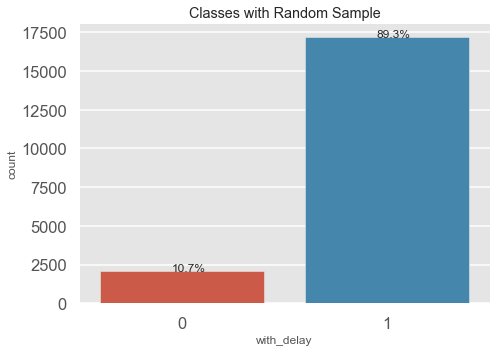

In [214]:
sns.set_context("talk")
plt.style.use('ggplot')
plt.figure(figsize=(7,5))

ax = sns.countplot(x="with_delay",data=y)

without_hue(ax, y)

plt.title("Classes with Random Sample")

plt.tight_layout()
plt.show()

$~$ 

it can be seen in the previous plot, the classes are still unbalanced

$~$ 

$~$ 

#####  SMOTE sample & Random Under Sample (smru):


$~$ 


+  first applying SMOTE to bring the minority class distribution to 30 percent of the majority class, This means:

    +  $1 = 17216$
    + $17216*0.3 = 5164$
    + $0= 5164$
    
$~$ 

+ them applying RandmUnderSample to bring the majority class down to 60 percent more than the minority class:

    +   $5164 / 0.6 = 8606$
    +   $0 = 8606$
    
    + finally:

    +  $0 = 8606$
    +  $1= 5164$


$~$ 


In [215]:
sm = SMOTE(sampling_strategy=0.3, random_state=42)
ru = RandomUnderSampler(sampling_strategy=0.6,random_state=42)

pipeline = Pipeline(steps=[('smote', sm), ('random_under', ru)])

X_smru,y_smru = pipeline.fit_resample(X,y)



In [216]:
y_smru.value_counts()

with_delay
1             8606
0             5164
dtype: int64

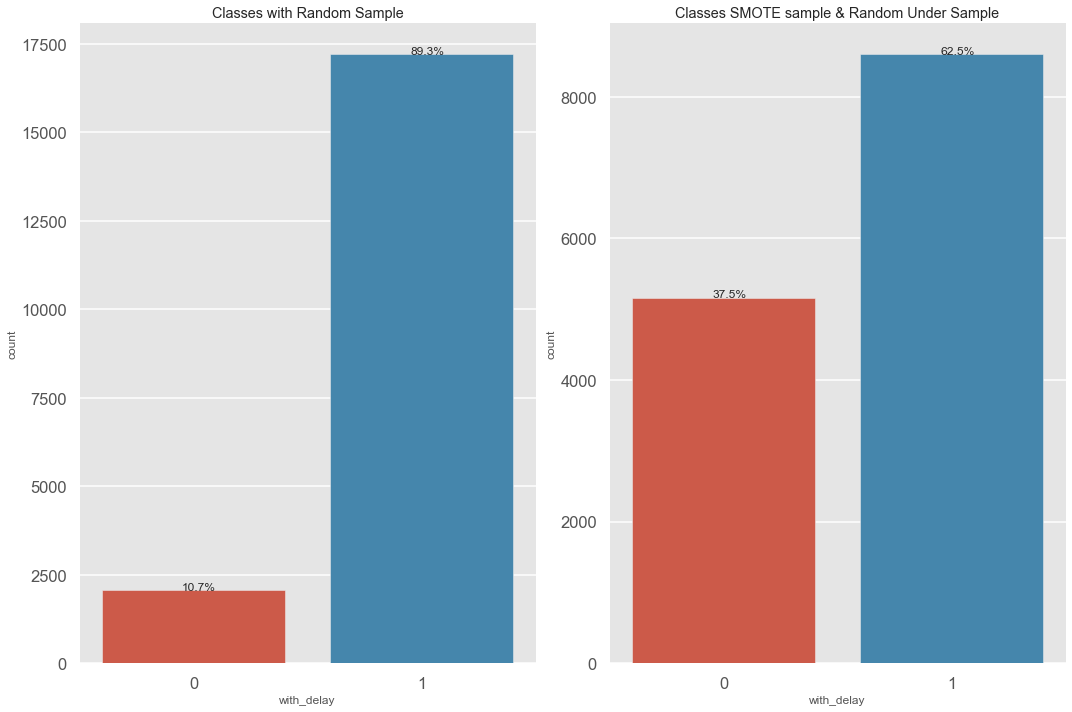

In [218]:
sns.set_context("talk")
plt.style.use('ggplot')

fig,axes = plt.subplots(1,2, figsize=(15,10))

ax = sns.countplot(x="with_delay",data=y,ax=axes[0])

ax2 = sns.countplot(x="with_delay",data=y_smru, ax=axes[1])

without_hue(ax, y)
without_hue(ax2, y_smru)


axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_title("Classes with Random Sample")

axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_title("Classes SMOTE sample & Random Under Sample")


plt.tight_layout()
plt.show()


$~$

Given the two types of samples below, we can see, on the one hand, that using the random sample, the imbalance of the classes is transmitted from the population to the sample. And on the other hand, using the SMOTE and RUS methods we can modify the ratio between the samples. From these two types of sample (with unbalanced classes and with balanced classes) let's see how the models behave.

$~$

$~$
___
####  Exercise 1

$~$

Create at least three different classification models to try to best predict DelayedFlights.csv flight delay (ArrDelay). Consider whether the flight is late or not (ArrDelay> 0).

$~$
___

$~$

There are many classification algorithms, however, for this exercise and to make comparisons between them, we are going to use three different algorithms. At the same time, we are going to propose three models per algorithm, it will help us to see how unbalanced classes affect each algorithm. Thus, we are going to performace the following models:

$~$

+   Logistic regresion:

    + with unbalanced classes
    + with SMOTE & Random Under Sample (RUS)
    + with class_weight = "balanced". The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

    
$~$

+   Support vector machine classifier (SVC):

    + with unbalanced classes
    + with SMOTE & Random Under Sample (RUS)
    + with class_weight = "balanced". 

$~$


+   K-Nearest Neighbors classifier (KNC):

    + with unbalanced classes   
    + with SMOTE & Random Under Sample (RUS)
    + with weights="distance" 


$~$


$~$

Note that the third model for each algorithm (with class_weight or weights -for KNN -) we are using a hyperparameter that Scikit-learn provides us to tell the model that we have unbalanced classes. In this sense, we are interested in checking the performance of our models using unbalanced classes, balanced classes (with SMOTE and RUS) and using this hyperparameter.

$~$

$~$

+   **Logistic regresion**:

$~$

model 1: with unbalanced classes


In [41]:
#with unbalanced classes

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y, stratify=y, test_size=0.30, random_state=42)

mod1 = LogisticRegression()
mod1.fit(X_train1,y_train1)
y_pred1 = mod1.predict(X_test1)

#keep scrore
report1 = classification_report(y_test1, y_pred1,output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1= df1.rename("Log regre (with unbalanced): " '{}'.format)

#keep confusion matrix
cf_matrix1 = confusion_matrix(y_test1, y_pred1)
#keep acurracy
acu1 = accuracy_score(y_test1, y_pred1)
#keep AUC
auc1 = roc_auc_score(y_test1, y_pred1)

model 2: with SMOTE sample & Random Under Sample (RUS)

In [42]:
#with SMOTE sample & Random Under Sample 
from imblearn.pipeline import Pipeline

sm = SMOTE(sampling_strategy=0.3, random_state=42)
ru = RandomUnderSampler(sampling_strategy=0.6,random_state=42)

pipeline = Pipeline(steps=[('smote', sm), ('random_under', ru)])

X_smru,y_smru = pipeline.fit_resample(X,y)



In [43]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
   X_smru,y_smru, stratify=y_smru, test_size=0.30, random_state=42)

mod2 = LogisticRegression()

#to avoid ValueError: Input contains NaN, infinity or a value too large for dtype('float64')
X_train2 = np.nan_to_num(X_train2)  
y_train2 = np.nan_to_num(y_train2)  
X_test2 = np.nan_to_num(X_test2)  

mod2.fit(X_train2,y_train2)

y_pred2 = mod2.predict(X_test2)

#keep scrore
report2 = classification_report(y_test2, y_pred2 ,output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2= df2.rename("Log regre (with SMOTE & RUS) : " '{}'.format)
#keep confusion matrix
cf_matrix2 = confusion_matrix(y_test2, y_pred2)
#keep acurracy
acu2 = accuracy_score(y_test2, y_pred2)
#keep AUC
auc2 = roc_auc_score(y_test2, y_pred2)

model 3: with class_weight = "balanced"

In [44]:
#with class_weight = balanced

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X, y, stratify=y, test_size=0.30, random_state=42)

mod3 = LogisticRegression(class_weight = "balanced")
mod3.fit(X_train3,y_train3)
y_pred3 = mod3.predict(X_test3)

#keep report 
report3 = classification_report(y_test3, y_pred3 ,output_dict=True)
df3 = pd.DataFrame(report3).transpose()
df3= df3.rename("Log regre (with class_weigh) : " '{}'.format)
#keeop confusion matrix
#keep confusion matrix
cf_matrix3 = confusion_matrix(y_test3, y_pred3)
#keep acurracy
acu3 = accuracy_score(y_test3, y_pred3)
#keep AUC
auc3 = roc_auc_score(y_test3, y_pred3)

$~$

+  **Support vector machine classifier (SVC)**:

$~$

model 4: with unbalanced classes


In [114]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X, y, stratify=y, test_size=0.30, random_state=42)

mod4 = svm.SVC(probability=True)
mod4.fit(X_train4,y_train4)
y_pred4 = mod4.predict(X_test4)

#keep scrore
report4 = classification_report(y_test4, y_pred4,output_dict=True)
df4 = pd.DataFrame(report4).transpose()
df4= df4.rename("SVC (with unbalanced): " '{}'.format)

#keep confusion matrix
cf_matrix4 = confusion_matrix(y_test4, y_pred4)
#keep acurracy
acu4 = accuracy_score(y_test4, y_pred4)
#keep AUC
auc4 = roc_auc_score(y_test4, y_pred4)

model 5: with SMOTE sample & Random Under Sample (RUS)

In [115]:

X_train5, X_test5, y_train5, y_test5 = train_test_split(
   X_smru,y_smru, stratify=y_smru, test_size=0.30, random_state=42)

mod5= svm.SVC(probability=True)

#to avoid ValueError: Input contains NaN, infinity or a value too large for dtype('float64')
X_train5 = np.nan_to_num(X_train5)  
y_train5 = np.nan_to_num(y_train5)  
X_test5 = np.nan_to_num(X_test5)

mod5.fit(X_train5,y_train5)

y_pred5 = mod5.predict(X_test5)

#keep scrore
report5 = classification_report(y_test5, y_pred5 ,output_dict=True)
df5 = pd.DataFrame(report5).transpose()
df5= df5.rename("SVC (with SMOTE & RUS) : " '{}'.format)
#keep confusion matrix
cf_matrix5 = confusion_matrix(y_test5, y_pred5)
#keep acurracy
acu5 = accuracy_score(y_test5, y_pred5)
#keep AUC
auc5 = roc_auc_score(y_test5, y_pred5)


model 6 = with class_weight = "balanced"

In [116]:
#with class_weight = balanced

X_train6, X_test6, y_train6, y_test6 = train_test_split(
    X, y, stratify=y, test_size=0.30, random_state=42)

mod6= svm.SVC(probability=True,class_weight = "balanced")

mod6.fit(X_train6,y_train6)
y_pred6 = mod6.predict(X_test6)

#keep report 
report6 = classification_report(y_test6, y_pred6 ,output_dict=True)
df6 = pd.DataFrame(report6).transpose()
df6= df6.rename("SVC (with class_weigh) : " '{}'.format)
#keeop confusion matrix
#keep confusion matrix
cf_matrix6 = confusion_matrix(y_test6, y_pred6)
#keep acurracy
acu6 = accuracy_score(y_test6, y_pred6)
#keep AUC
auc6 = roc_auc_score(y_test6, y_pred6)

$~$

+   **K-Nearest Neighbors classifier (KNNC):**

$~$

model 7: with unbalanced classes

In [219]:
#with unbalanced classes

X_train7, X_test7, y_train7, y_test7 = train_test_split(
    X, y, stratify=y, test_size=0.30, random_state=42)

mod7 = KNeighborsClassifier()
mod7.fit(X_train7,y_train7)
y_pred7 = mod7.predict(X_test7)

#keep scrore
report7 = classification_report(y_test7, y_pred7,output_dict=True)
df7 = pd.DataFrame(report7).transpose()
df7= df7.rename("KNN (with unbalanced): " '{}'.format)

#keep confusion matrix
cf_matrix7 = confusion_matrix(y_test7, y_pred7)
#keep acurracy
acu7 = accuracy_score(y_test7, y_pred7)
#keep AUC
auc7 = roc_auc_score(y_test7, y_pred7)

model 8: with SMOTE sample & Random Under Sample (RUS)

In [220]:
X_train8, X_test8, y_train8, y_test8 = train_test_split(
   X_smru,y_smru, stratify=y_smru, test_size=0.30, random_state=42)

mod8= KNeighborsClassifier()

#to avoid ValueError: Input contains NaN, infinity or a value too large for dtype('float64')
X_train8 = np.nan_to_num(X_train8)  
y_train8 = np.nan_to_num(y_train8)  
X_test8 = np.nan_to_num(X_test8)

mod8.fit(X_train8,y_train8)

y_pred8 = mod8.predict(X_test8)

#keep scrore
report8 = classification_report(y_test8, y_pred8 ,output_dict=True)
df8 = pd.DataFrame(report8).transpose()
df8= df8.rename("KNN (with SMOTE & RUS) : " '{}'.format)
#keep confusion matrix
cf_matrix8 = confusion_matrix(y_test8, y_pred8)
#keep acurracy
acu8 = accuracy_score(y_test8, y_pred8)
#keep AUC
auc8 = roc_auc_score(y_test8, y_pred8)

model 9: with weights="distance"

In [221]:
#with class_weight = balanced

X_train9, X_test9, y_train9, y_test9 = train_test_split(
    X, y, stratify=y, test_size=0.30, random_state=42)

mod9= KNeighborsClassifier(weights="distance")

mod9.fit(X_train9,y_train9)
y_pred9 = mod9.predict(X_test9)


In [222]:

#keep report 
report9 = classification_report(y_test9, y_pred9 ,output_dict=True)
df9 = pd.DataFrame(report9).transpose()
df9= df9.rename("KNN (with weights=distance) : " '{}'.format)
#keeop confusion matrix
#keep confusion matrix
cf_matrix9 = confusion_matrix(y_test9, y_pred9)
#keep acurracy
acu9 = accuracy_score(y_test9, y_pred9)
#keep AUC
auc9 = roc_auc_score(y_test9, y_pred9)

$~$
___
####  Exercise 2

$~$

Compare classification models using accuracy, a confidence matrix, and other more advanced metrics.

$~$
___

$~$

+ **Accuracy**: We can use accuracy -the fraction of correctly classified samples-  to measure model performance. However, accuracy is not always a useful metric, especially when we have unbalanced classes. This can be seen in the results of our models:

$~$

Accuracy Logistic regresion models:

In [174]:


print('MOD 1. Accuracy Log regresion model (unbalanced):',
      round(acu1, 4)*100, '%')
print('MOD 2. Accuracy Log regresion model (SMOTE & RUS sample):',
      round(acu2, 4)*100, '%')
print('MOD 3. Accuracy Log regresion model (class_weight = balanced):',
      round(acu3, 4)*100, '%')


MOD 1. Accuracy Log regresion model (unbalanced): 89.53999999999999 %
MOD 2. Accuracy Log regresion model (SMOTE & RUS sample): 82.84 %
MOD 3. Accuracy Log regresion model (class_weight = balanced): 77.96 %


Accuracy SVC models:

In [117]:
print('MOD 4. Accuracy SVC (unbalanced):', round(acu4, 4)*100, '%')
print('MOD 5. Accuracy SVC (SMOTE & RUS sample):', round(acu5, 4)*100, '%')
print('MOD 6. Accuracy SVC (class_weight = balanced):', round(acu6, 4)*100, '%')


MOD 4. Accuracy SVC (unbalanced): 89.28 %
MOD 5. Accuracy SVC (SMOTE & RUS sample): 79.38 %
MOD 6. Accuracy SVC (class_weight = balanced): 62.18 %


Accuracy KNN models:

In [54]:
print('MOD 7. Accuracy KNN (unbalanced):',round(acu7,4)*100,'%')
print('MOD 8. Accuracy KNN (SMOTE & RUS sample):',round(acu8,4)*100,'%')
print('MOD 9. Accuracy KNN (with weights="distance"):',round(acu9,4)*100,'%')


MOD 7. Accuracy KNN (unbalanced): 87.88 %
MOD 8. Accuracy KNN (SMOTE & RUS sample): 85.5 %
MOD 9. Accuracy KNN (with weights="distance"): 87.78 %


$~$

Note that for all 3 algorithms analyzed, the models with higher accuracy values are the models that use unbalanced classes (model 1, 4 and 7).Although the accuracy values are high (remember that the closer this value is to 1, the better the metric is) in this exercise we cannot trust this metric. Since the high values of this metric are due to the fact that the models (which use unbalanced classes) do not filter between classes but assign each of the elements to the majority class. This will be better in the next section.

$~$

Let's see then another metric that can help us measure the quality of our models

$~$

 $~$

 + **Confusion matrix**: A much better way to evaluate the performance of a classifier is to look at the confusion matrix, to interpret the matrix in the context of this exercise we must take into account the following:
 
 $~$

 +  *True-Positive*: flights that arrived delayed and that the model classified as delayed.

 +  *True-Negative*: flights that arrived on time and were classified as on time.

 + *False-Negative*: flights that arrived delayed but were classified as on time.
 
 + *False-Positive*: flights that arrived on time but were classified as delayed.

 $~$
 
Since we are working with unbalanced classes, we must take into account that the models will better classify the majority class (True-Positive values). Therefore, we are interested in paying special attention to those models with higher **True-Negative values** (values of the minority class that were correctly classified) in the confusion matrix.

 $~$
 
+ confusion matrix Logistic regresion models:

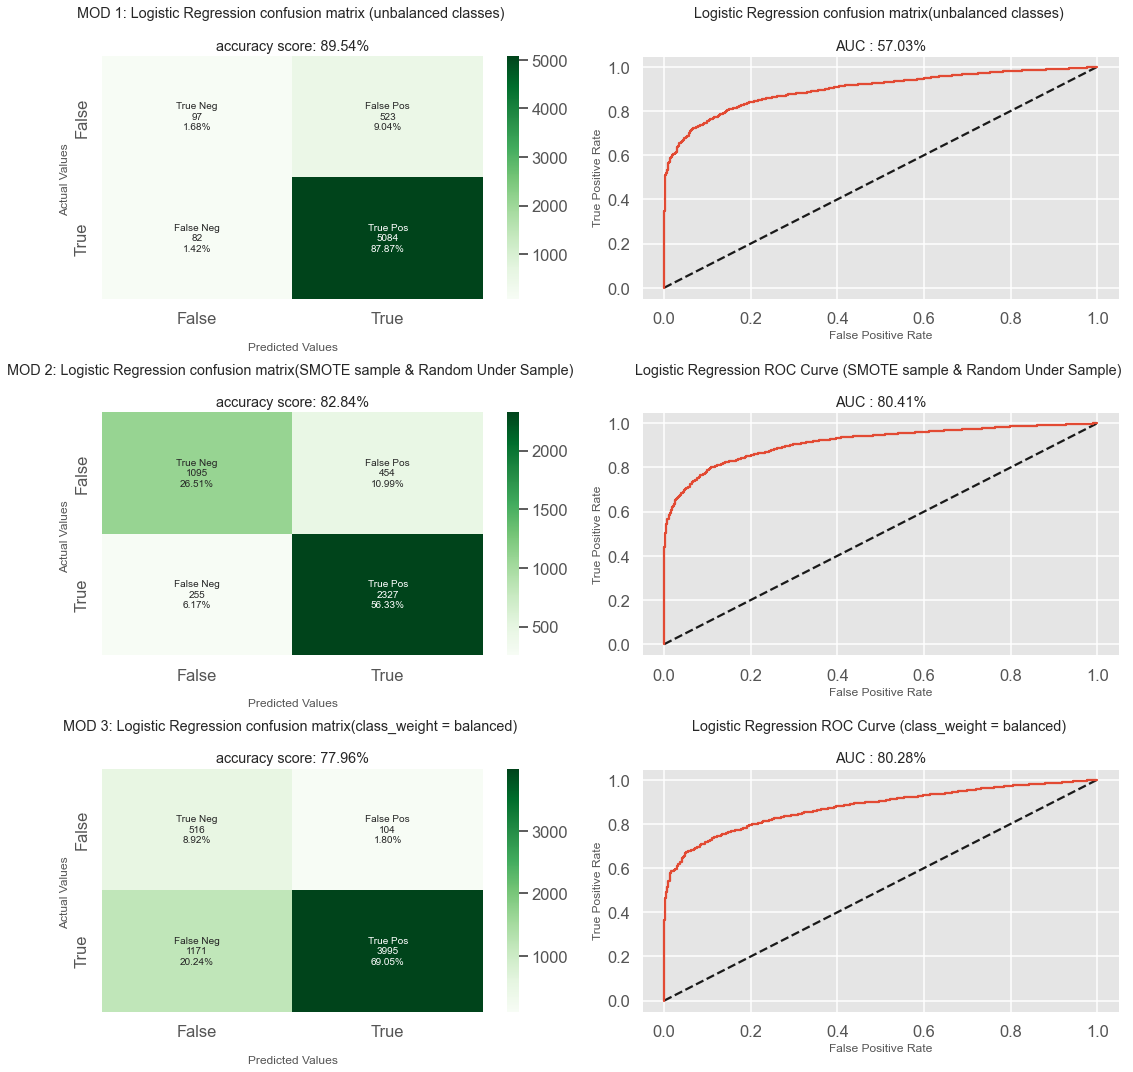

In [55]:
sns.set_context("talk")
plt.style.use('ggplot')

fig, axes = plt.subplots(3,2,figsize=(15,15),alpha=0.5)
group_names = ['True Neg','False Pos','False Neg','True Pos']

######## plot confidence matrix

#plot Logistic Regression

    # mod1 = logistic regresion unblance classes
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix1.flatten()/np.sum(cf_matrix1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix1, annot=labels, fmt='', cmap='Greens',ax=axes[0,0])
axes[0,0].set_title('MOD 1: Logistic Regression confusion matrix (unbalanced classes) \n\n' + "accuracy score: {0:.2%}".format(acu1));
axes[0,0].set_xlabel('\nPredicted Values')
axes[0,0].set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
axes[0,0].xaxis.set_ticklabels(['False','True'])
axes[0,0].yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.

    #mod 2 = logistic regresion SMOTE & RUS classes
group_counts = ["{0:0.0f}".format(value) for value in
cf_matrix2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cf_matrix2.flatten()/np.sum(cf_matrix2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix2, annot=labels, fmt='', cmap='Greens',ax=axes[1,0])
axes[1,0].set_title('MOD 2: Logistic Regression confusion matrix(SMOTE sample & Random Under Sample) \n\n' + "accuracy score: {0:.2%}".format(acu2));
axes[1,0].set_xlabel('\nPredicted Values')
axes[1,0].set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
axes[1,0].xaxis.set_ticklabels(['False','True'])
axes[1,0].yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.

    #mod 3 = logistic regresion with class_weight
group_counts = ["{0:0.0f}".format(value) for value in
cf_matrix3.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cf_matrix3.flatten()/np.sum(cf_matrix3)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix3, annot=labels, fmt='', cmap='Greens',ax=axes[2,0])
axes[2,0].set_title('MOD 3: Logistic Regression confusion matrix(class_weight = balanced) \n\n'+ "accuracy score: {0:.2%}".format(acu3));
axes[2,0].set_xlabel('\nPredicted Values')
axes[2,0].set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
axes[2,0].xaxis.set_ticklabels(['False','True'])
axes[2,0].yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.

######## ROC curves

#plot Logistic Regression


    # mod1 = logistic regresion unblance classes

y_pred_prob1 = mod1.predict_proba(X_test1)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test1, y_pred_prob1)
axes[0,1].plot([0, 1], [0, 1], 'k--')
axes[0,1].plot(fpr1, tpr1, label='Logistic Regression')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('Logistic Regression confusion matrix(unbalanced classes) \n\n'+ "AUC : {0:.2%}".format(auc1))

    #mod 2 = logistic regresion SMOTE & RUS classes


y_pred_prob2 = mod2.predict_proba(X_test2)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test2, y_pred_prob2)
axes[1,1].plot([0, 1], [0, 1], 'k--')
axes[1,1].plot(fpr2, tpr2, label='Logistic Regression')
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].set_title('Logistic Regression ROC Curve (SMOTE sample & Random Under Sample) \n\n'+ "AUC : {0:.2%}".format(auc2))

    #mod 3 = logistic regresion with class_weight


y_pred_prob3 = mod3.predict_proba(X_test3)[:,1]
fpr3, tpr3, thresholds3 = roc_curve(y_test3, y_pred_prob3)

axes[2,1].plot([0, 1], [0, 1], 'k--')
axes[2,1].plot(fpr3, tpr3, label='Logistic Regression')
axes[2,1].set_xlabel('False Positive Rate')
axes[2,1].set_ylabel('True Positive Rate')
axes[2,1].set_title('Logistic Regression ROC Curve (class_weight = balanced) \n\n' +"AUC : {0:.2%}".format(auc3))

plt.tight_layout()
plt.show()

 $~$
 
+ confusion matrix SVM models:

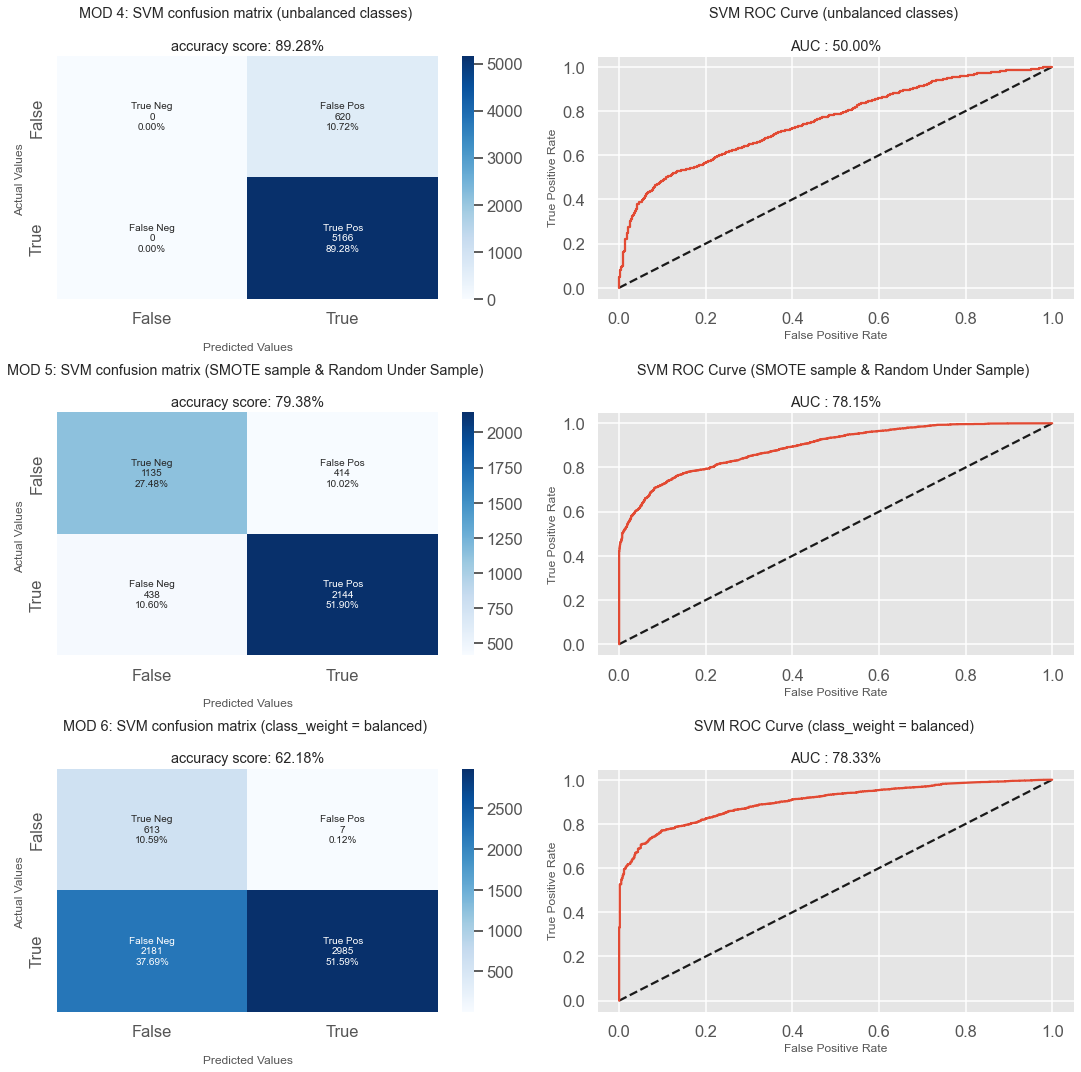

In [123]:
sns.set_context("talk")
plt.style.use('ggplot')

fig, axes = plt.subplots(3,2,figsize=(15,15),alpha=0.5)
group_names = ['True Neg','False Pos','False Neg','True Pos']

######## plot confidence matrix
#plot SVM


 # mod 4 = SVM unblance classes
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix4.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix4.flatten()/np.sum(cf_matrix4)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix4, annot=labels, fmt='', cmap='Blues',ax=axes[0,0])
axes[0,0].set_title('MOD 4: SVM confusion matrix (unbalanced classes) \n\n' + "accuracy score: {0:.2%}".format(acu4));
axes[0,0].set_xlabel('\nPredicted Values')
axes[0,0].set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
axes[0,0].xaxis.set_ticklabels(['False','True'])
axes[0,0].yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.

    #mod 5 = SVM SMOTE & RUS classes
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix5.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix5.flatten()/np.sum(cf_matrix5)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix5, annot=labels, fmt='', cmap='Blues',ax=axes[1,0])
axes[1,0].set_title('MOD 5: SVM confusion matrix (SMOTE sample & Random Under Sample) \n\n' + "accuracy score: {0:.2%}".format(acu5));
axes[1,0].set_xlabel('\nPredicted Values')
axes[1,0].set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
axes[1,0].xaxis.set_ticklabels(['False','True'])
axes[1,0].yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.

    #mod 6 = SVM with class_weight

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix6.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix6.flatten()/np.sum(cf_matrix6)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix6, annot=labels, fmt='', cmap='Blues',ax=axes[2,0])
axes[2,0].set_title('MOD 6: SVM confusion matrix (class_weight = balanced) \n\n' + "accuracy score: {0:.2%}".format(acu6));
axes[2,0].set_xlabel('\nPredicted Values')
axes[2,0].set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
axes[2,0].xaxis.set_ticklabels(['False','True'])
axes[2,0].yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.

######## ROC curves

#plot SVM

    # mod4 = SVM unbAlance classes

y_pred_prob4 = mod4.predict_proba(X_test4)[:,1]
fpr4, tpr4, thresholds4 = roc_curve(y_test4, y_pred_prob4)

axes[0,1].plot([0, 1], [0, 1], 'k--')
axes[0,1].plot(fpr4, tpr4, label='SVM')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('SVM ROC Curve (unbalanced classes) \n\n' +"AUC : {0:.2%}".format(auc4))

    #mod 5 = SVM SMOTE & RUS classes

y_pred_prob5 = mod5.predict_proba(X_test5)[:,1]
fpr5, tpr5, thresholds5 = roc_curve(y_test5, y_pred_prob5)

axes[1,1].plot([0, 1], [0, 1], 'k--')
axes[1,1].plot(fpr5, tpr5, label='SVM')
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].set_title('SVM ROC Curve (SMOTE sample & Random Under Sample) \n\n' +"AUC : {0:.2%}".format(auc5))

        #mod 6 = SVM with class_weight

y_pred_prob6 = mod6.predict_proba(X_test6)[:,1]
fpr6, tpr6, thresholds6 = roc_curve(y_test6, y_pred_prob6)

axes[2,1].plot([0, 1], [0, 1], 'k--')
axes[2,1].plot(fpr6, tpr6, label='SVM')
axes[2,1].set_xlabel('False Positive Rate')
axes[2,1].set_ylabel('True Positive Rate')
axes[2,1].set_title('SVM ROC Curve (class_weight = balanced) \n\n' +"AUC : {0:.2%}".format(auc6))

plt.tight_layout()
plt.show()

 $~$
 
+ confusion matrix KNN models:

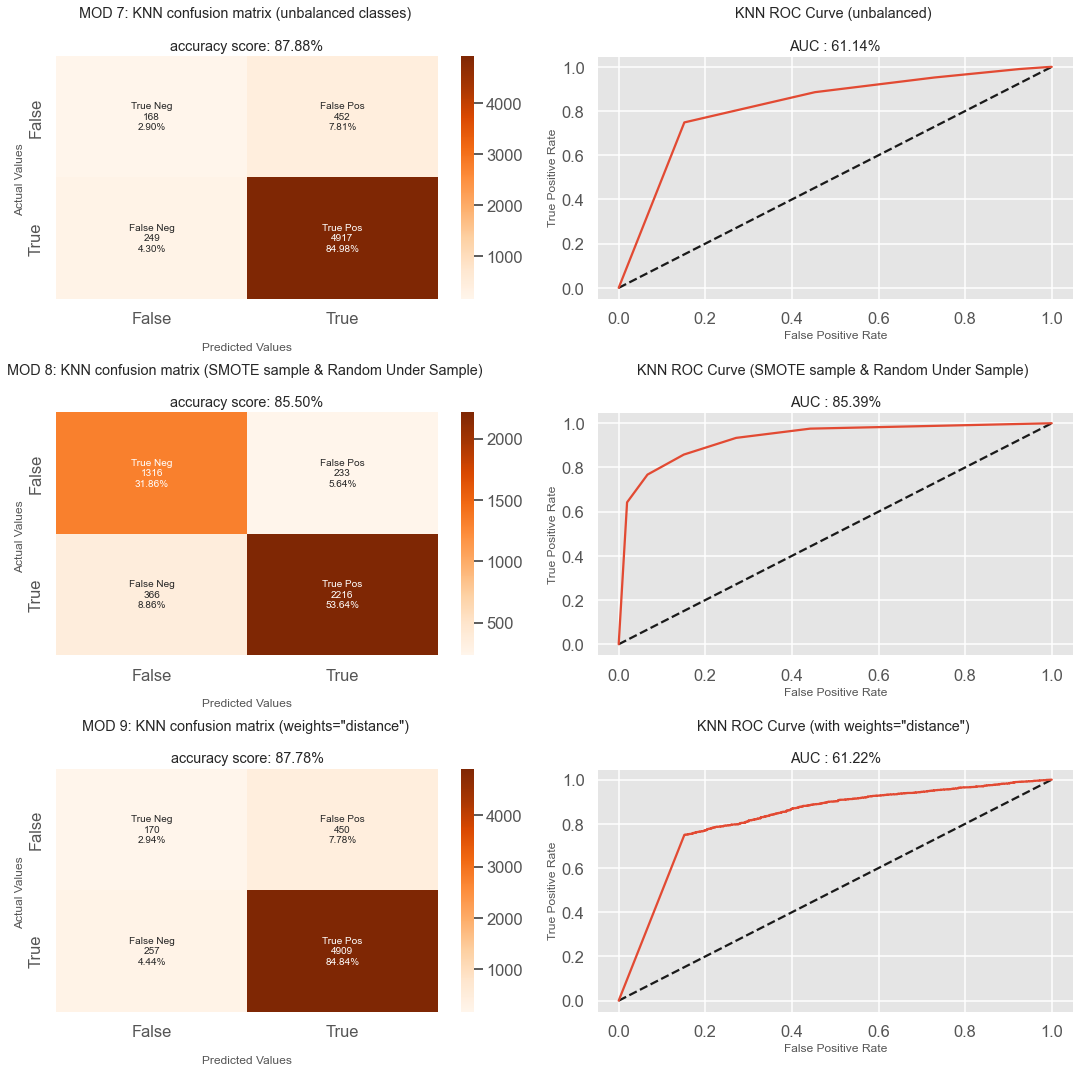

In [224]:
sns.set_context("talk")
plt.style.use('ggplot')

fig, axes = plt.subplots(3,2,figsize=(15,15),alpha=0.5)
group_names = ['True Neg','False Pos','False Neg','True Pos']

######## plot confidence matrix

#plot KNN

    #mod 7 = KNN with unbalanced classes

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix7.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix7.flatten()/np.sum(cf_matrix7)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix7, annot=labels, fmt='', cmap='Oranges',ax=axes[0,0])
axes[0,0].set_title('MOD 7: KNN confusion matrix (unbalanced classes) \n\n' + "accuracy score: {0:.2%}".format(acu7));
axes[0,0].set_xlabel('\nPredicted Values')
axes[0,0].set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
axes[0,0].xaxis.set_ticklabels(['False','True'])
axes[0,0].yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.

    #mod 8 = KNN with SMOTE & RUS 
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix8.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix8.flatten()/np.sum(cf_matrix8)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix8, annot=labels, fmt='', cmap='Oranges',ax=axes[1,0])
axes[1,0].set_title('MOD 8: KNN confusion matrix (SMOTE sample & Random Under Sample) \n\n' + "accuracy score: {0:.2%}".format(acu8));
axes[1,0].set_xlabel('\nPredicted Values')
axes[1,0].set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
axes[1,0].xaxis.set_ticklabels(['False','True'])
axes[1,0].yaxis.set_ticklabels(['False','True'])

    #mod 9 = KNN with weights="distance".
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix9.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix9.flatten()/np.sum(cf_matrix9)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix9, annot=labels, fmt='', cmap='Oranges',ax=axes[2,0])
axes[2,0].set_title('MOD 9: KNN confusion matrix (weights="distance") \n\n' + "accuracy score: {0:.2%}".format(acu9));
axes[2,0].set_xlabel('\nPredicted Values')
axes[2,0].set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
axes[2,0].xaxis.set_ticklabels(['False','True'])
axes[2,0].yaxis.set_ticklabels(['False','True'])


######## ROC curves
#plot KNC

    #mod 7 = KNC unbalanced

y_pred_prob7 = mod7.predict_proba(X_test7)[:,1]
#calcule fpr, tpr, and thresholds
fpr7, tpr7, thresholds7 = roc_curve(y_test7, y_pred_prob7)

axes[0,1].plot([0, 1], [0, 1], 'k--')
axes[0,1].plot(fpr7, tpr7, label='KNC')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('KNN ROC Curve (unbalanced) \n\n' +"AUC : {0:.2%}".format(auc7))


   #mod 8 = KNN SMOTE & Random Under Sample (RUS)

y_pred_prob8 = mod8.predict_proba(X_test8)[:,1]
fpr8, tpr8, thresholds8 = roc_curve(y_test8, y_pred_prob8)

axes[1,1].plot([0, 1], [0, 1], 'k--')
axes[1,1].plot(fpr8, tpr8, label='KNC')
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].set_title('KNN ROC Curve (SMOTE sample & Random Under Sample) \n\n' +"AUC : {0:.2%}".format(auc8))


   #mod 9 = KNC with class_weight

y_pred_prob9 = mod9.predict_proba(X_test9)[:,1]
fpr9, tpr9, thresholds9 = roc_curve(y_test9, y_pred_prob9)

axes[2,1].plot([0, 1], [0, 1], 'k--')
axes[2,1].plot(fpr9, tpr9, label='KNC')
axes[2,1].set_xlabel('False Positive Rate')
axes[2,1].set_ylabel('True Positive Rate')
axes[2,1].set_title('KNN ROC Curve (with weights="distance") \n\n' +"AUC : {0:.2%}".format(auc9))


plt.tight_layout()
plt.show()

$~$

+ **Confusion matrix give us a more complete picture of how our model performing**: In the previous plots it is observed that the models with the highest accuracy value (1,4,7), if we evaluate them using the confidence matrix, are not exactly the best models since they have the lowest ratio of **True-Negative** values. Regardless of the algorithm, the best models (if we evaluate them with the confusion matrix) are those that we work with SMOTE and RUS samples

In addition to the confusion matrix, the **ROC curve** (along with the **AUC value**) is also shown in the plots above.


$~$

From what we see in the graphs above. (where we can also observe the ROC curve) the best results are obtained by models that take into account unbalanced classes.

$~$

Despite the fact that models 2, 5, 8 are not the ones with the highest value of **acurracy**, they are the ones with the highest percentage of **True-negative** values (that is, flights that arrived on time and the model predicted them as such). At the same time, these models are the ones with the best **Area Under the Curve (AUC)** scores.

$~$

for what we seen, AUC is a useful **as a single number summary** of classifier performace and even when there is **class imbalance**


$~$


$~$

+  **Classification Report**: the final classification model evaluation metric we're going to look at is a Classification Report. It is more a collection of different evaluatrion metrics rather that a single one. Before showing the results, let's keep clear the means of the metrics we can get with the classification report:
$~$


    + **Precision**: indicate the propotion of positie identifications(model predicted class 1) which were actually correct. A model which produces no false positives has a precision of 1.0.
    + **Recall**: Indicates the proportion of actual positives which were correctyle classified. A model which produce no false negatives has recall of 1.0.
    + **F1 scores**: A combination opf precision and recall. A perfect model achieves an F1 scores of 1.0
    + **Accuracy**: The accuracy of the model in decimal form. Perfect accuracy is equal to 1.0
    + **Macro avg**: short for macro average, the average precision, recall and F1 between classes. Macro avg doesn't class imbalance into count, so having class imbalance, be should pay attention to this metric
    + **Weighted avg**: Short for weighted average, the weighted average precision, recall and F1 score betwwen classes. Weighted means each metric is calculated with respect to how many samples there are in each class. *this metric will favour the majority class.

$~$

For all these metrics, we need to pay special attention to the metrics in the component 0 (this is our minority class as we are working with unbalanced classes) of the report. Since these will allow us to evaluate ours models


+ Classification report logistic regresion models:

In [168]:
#Classification report Log regre (with unbalanced classes)
df1

,precision,recall,f1-score,support
Log regre (with unbalanced): 0,0.541899,0.156452,0.242804,620.000000
Log regre (with unbalanced): 1,0.906724,0.984127,0.943841,5166.000000
Log regre (with unbalanced): accuracy,0.895437,0.895437,0.895437,0.895437
Log regre (with unbalanced): macro avg,0.724312,0.570289,0.593322,5786.000000
Log regre (with unbalanced): weighted avg,0.867631,0.895437,0.868721,5786.000000


In [169]:
#Classification report Log regre (with SMOTE & RUS)
df2

,precision,recall,f1-score,support
Log regre (with SMOTE & RUS) : 0,0.811111,0.706908,0.755433,1549.000000
Log regre (with SMOTE & RUS) : 1,0.836749,0.901239,0.867798,2582.000000
Log regre (with SMOTE & RUS) : accuracy,0.828371,0.828371,0.828371,0.828371
Log regre (with SMOTE & RUS) : macro avg,0.823930,0.804074,0.811615,4131.000000
Log regre (with SMOTE & RUS) : weighted avg,0.827136,0.828371,0.825664,4131.000000


In [170]:
# Classification report Log regre (with class_weigh)
df3

,precision,recall,f1-score,support
Log regre (with class_weigh) : 0,0.305868,0.832258,0.447334,620.000000
Log regre (with class_weigh) : 1,0.974628,0.773326,0.862385,5166.000000
Log regre (with class_weigh) : accuracy,0.779641,0.779641,0.779641,0.779641
Log regre (with class_weigh) : macro avg,0.640248,0.802792,0.654860,5786.000000
Log regre (with class_weigh) : weighted avg,0.902967,0.779641,0.817910,5786.000000


$~$

+ Classification report SVM models:

In [171]:
#Classification report SVM (with unbalanced classes)
df4

,precision,recall,f1-score,support
SVC (with unbalanced): 0,0.000000,0.000000,0.000000,620.000000
SVC (with unbalanced): 1,0.892845,1.000000,0.943389,5166.000000
SVC (with unbalanced): accuracy,0.892845,0.892845,0.892845,0.892845
SVC (with unbalanced): macro avg,0.446422,0.500000,0.471695,5786.000000
SVC (with unbalanced): weighted avg,0.797172,0.892845,0.842300,5786.000000


In [172]:
#Classification report SVM ((with SMOTE & RUS))
df5

,precision,recall,f1-score,support
SVC (with SMOTE & RUS) : 0,0.721551,0.732731,0.727098,1549.000000
SVC (with SMOTE & RUS) : 1,0.838155,0.830364,0.834241,2582.000000
SVC (with SMOTE & RUS) : accuracy,0.793755,0.793755,0.793755,0.793755
SVC (with SMOTE & RUS) : macro avg,0.779853,0.781547,0.780670,4131.000000
SVC (with SMOTE & RUS) : weighted avg,0.794432,0.793755,0.794066,4131.000000


In [173]:
#Classification report SVM (with class_weigh)
df6

,precision,recall,f1-score,support
SVC (with class_weigh) : 0,0.219399,0.988710,0.359110,620.000000
SVC (with class_weigh) : 1,0.997660,0.577816,0.731797,5166.000000
SVC (with class_weigh) : accuracy,0.621846,0.621846,0.621846,0.621846
SVC (with class_weigh) : macro avg,0.608530,0.783263,0.545453,5786.000000
SVC (with class_weigh) : weighted avg,0.914266,0.621846,0.691862,5786.000000


$~$

+ classification report KNN models:

In [175]:
#Classification report KNN (with unbalanced classes)
df7

,precision,recall,f1-score,support
KNN (with unbalanced): 0,0.402878,0.270968,0.324012,620.000000
KNN (with unbalanced): 1,0.915813,0.951800,0.933460,5166.000000
KNN (with unbalanced): accuracy,0.878845,0.878845,0.878845,0.878845
KNN (with unbalanced): macro avg,0.659345,0.611384,0.628736,5786.000000
KNN (with unbalanced): weighted avg,0.860849,0.878845,0.868154,5786.000000


In [176]:
#Classification report KNN (with SMOTE & RUS)
df8

,precision,recall,f1-score,support
KNN (with SMOTE & RUS) : 0,0.782402,0.849580,0.814608,1549.000000
KNN (with SMOTE & RUS) : 1,0.904859,0.858249,0.880938,2582.000000
KNN (with SMOTE & RUS) : accuracy,0.854999,0.854999,0.854999,0.854999
KNN (with SMOTE & RUS) : macro avg,0.843631,0.853915,0.847773,4131.000000
KNN (with SMOTE & RUS) : weighted avg,0.858941,0.854999,0.856067,4131.000000


In [178]:
#Classification report KNN (with weights="distance")
df9

,precision,recall,f1-score,support
KNN (with class_weigh) : 0,0.398126,0.274194,0.324737,620.000000
KNN (with class_weigh) : 1,0.916029,0.950252,0.932827,5166.000000
KNN (with class_weigh) : accuracy,0.877809,0.877809,0.877809,0.877809
KNN (with class_weigh) : macro avg,0.657078,0.612223,0.628782,5786.000000
KNN (with class_weigh) : weighted avg,0.860533,0.877809,0.867667,5786.000000


$~$

+ note that, regardless of the classification algorithm used, the models that best predict are those in which we use **SMOTE and RUS samples**. This is observed in the values of precision, recall and f1-score (in component 0 of the reports). This coincides with the results obtained in the confusion matrix as well as in the **AUC** values.

+ On the other hand, of the three algorithms tested, both in terms of computation time and results, **the K-Nearest Neighbors classifier** is the one that offers the best results.

$~$

$~$
___
####  Exercise 3

$~$

Train them using the different parameters they support.

$~$
___

$~$

For this exercise, we are going to tuned the hyperparameters of the models that, from what we have seen in the previous section, do not have the best results. Specifically, we are going to work with mod 1 and mod 7. These models have an AUC=57.03 and AUC= 61.14, respectively. let's find out if the results can be improved

$~$


+ tuning hyperparametres for Logistic regresion (mod 1)

In [57]:
# # Create training and test sets
X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(X, y,
test_size = 0.3, random_state=42)

# Setup the hyperparameter grid
parameters = {'penalty':["l1","elasticnet","l2"], 'solver':["sag","saga","lbfgs","liblinear"],'class_weight':[None,"balanced"]}
# Instantiate log regresion
mod2 = LogisticRegression()
#instantiate the GridSearchCV object: log_grid
log_grid = GridSearchCV(mod2,parameters,scoring='roc_auc')
# Fit it to the data
log_grid.fit(X_train_lg,y_train_lg)

# # Predict on the test data: y_pred
y_pred_log_grid = log_grid.predict(X_test_lg)



In [60]:
#keep confusion matrix
cf_matrix_log_grid = confusion_matrix(y_test1, y_pred_log_grid)
#keep acurracy
acu_log_grid = accuracy_score(y_test1, y_pred_log_grid)
#keep AUC
auc_log_grid = roc_auc_score(y_test1, y_pred_log_grid)

In [61]:
# Print the tuned parameters and score
print("Tuned log Regression Parameters: {}".format(log_grid.best_params_)) 



Tuned log Regression Parameters: {'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


In [154]:
print("Logist regresision AUC after tuned hyperparametres: {}".format(log_grid.best_score_))
print("Logist regresision AUC before tuned hyperparametres: {}".format(auc1))



Logist regresision AUC after tuned hyperparametres: 0.9208191396128436
Logist regresision AUC before tuned hyperparametres: 0.570289298515105


+ tuning hyperparametres for KNN model (mod 7):

In [63]:
# Setup the hyperparameter grid
parameters = {'weights':["uniform","distance"], 'algorithm':['auto','ball_tree','kd_tree'],'metric':['minkowski','chebyshev','euclidean']}
# Instantiate log regresion
mod8= KNeighborsClassifier()

#instantiate the GridSearchCV object: KNN_grid
KNN_grid = GridSearchCV(mod8,parameters)
# Fit it to the data
KNN_grid.fit(X_train8,y_train8)

# # Predict on the test data: y_pre
y_pred_KNN_grid = KNN_grid.predict(X_test8)



In [64]:
#keep confusion matrix
cf_matrix_KNN_grid = confusion_matrix(y_test8, y_pred_KNN_grid)
#keep acurracy
acu_KNN_grid = accuracy_score(y_test8, y_pred_KNN_grid)
#keep AUC
auc_KNN_grid = roc_auc_score(y_test8, y_pred_KNN_grid)

In [80]:
# Print the tuned parameters and score
print("Tuned KNN Parameters: {}".format(KNN_grid.best_params_)) 

Tuned KNN Parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'weights': 'distance'}


In [153]:
print("KNN AUC after tuned hyperparametres: {}".format(KNN_grid.best_score_))
print("KNN before tuned hyperparametres: {}".format(auc5))

KNN AUC after tuned hyperparametres: 0.8455237539485839
KNN before tuned hyperparametres: 0.7815474264648891


$~$

notice how the models can be improved (no matter what algorithm we use) if we run gridsearch on the hyperparameters (see how to improve the values of the **AUC**)

$~$

$~$
___
####  Exercise 4

$~$

Compare your performance using the train / test or cross-validation approach.

$~$
___

$~$

For this exercise, we are going to perform cross-validation taking into account the unbalanced classes, that is, the data with SMOTE and RUS will be used.

$~$

+ mod2 = Logistic regresion with SMOTE & Random Under Sample (RUS)
    
+ mod5 = SVC with SMOTE & Random Under Sample (RUS)

+ mod8 = KNN with SMOTE & Random Under Sample (RUS)

$~$

In addition, to show how the performance of our models is, we are going to use the AUC metric since, as we have seen in the previous sections, this is a valid metric when working with unbalanced classes.
$~$

+ cross-validation mod2: Logistic regresion with SMOTE & Random Under Sample (RUS)


In [120]:
# prepare the cross-validation procedure
# evaluate model

X_smru = np.nan_to_num(X_smru)  
y_smru = np.nan_to_num(y_smru) 
scores1 = cross_val_score(mod1,X_smru,y_smru, cv=5,
                                scoring='roc_auc')

In [225]:
print(scores1)
print("Average 5-Fold CV Score: {}".format(np.mean(scores1)))
print("Logist regresision AUC : {}".format(auc2))


[0.82030473 0.83842382 0.97356723 0.96380231 0.97800635]
Average 5-Fold CV Score: 0.9148208870635068
Logist regresision AUC : 0.8040735158586609


cross-validation mod5: SVC with SMOTE & Random Under Sample (RUS)

In [119]:
X_smru = np.nan_to_num(X_smru)  
y_smru = np.nan_to_num(y_smru) 

scores2 = cross_val_score(mod4,X_smru,y_smru, cv=5,
                                scoring='roc_auc')

In [226]:
print(scores2)
print("Average 5-Fold CV Score: {}".format(np.mean(scores2)))
print("SVC AUC : {}".format(auc5))


[0.84039087 0.84343115 0.92335497 0.92140874 0.91573819]
Average 5-Fold CV Score: 0.8888647827517324
SVC AUC : 0.7815474264648891


cross-validation mod8 KNN with SMOTE & Random Under Sample (RUS)

In [73]:
scores3 = cross_val_score(mod7,X_smru,y_smru, cv=5,
                                scoring='roc_auc')

In [227]:
print(scores3)
print("Average 5-Fold CV Score: {}".format(np.mean(scores2)))
print("KNN AUC : {}".format(auc8))


[0.84004859 0.84262594 0.97274823 0.97604614 0.97515649]
Average 5-Fold CV Score: 0.8888647827517324
KNN AUC : 0.8539148967450578


$~$

From the results obtained in the cross-validation (we have evaluated using the AUC values as a metric) we can understand that our models (for all algorithms) have an amount of underfitting. At the same time, this tells us that our models can be improved. This is precisely what we will do in the next section.

$~$


$~$
___
####  Exercise 5

$~$


Feature-engineering process to get better prediction.


$~$
___

$~$

to improve the model we are going to normalize the numeric variables (we are going to use normalized RobustScaler())
in the models where unbalanced classes have been taken into account, that is, in models 2, 5, 7

$~$

+ mod 2  Logistic regresion with SMOTE & Random Under Sample (RUS) and Robustscaler 

In [121]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_smru, y_smru, stratify=y_smru, test_size=0.30, random_state=42)


# to avoid ValueError: Input contains NaN, infinity or a value too large for dtype('float64')
X_train2 = np.nan_to_num(X_train2)
y_train2 = np.nan_to_num(y_train2)
X_test2 = np.nan_to_num(X_test2)


# Setup the pipeline steps: steps
steps = [("normalizer", RobustScaler(quantile_range=(25.0, 60.0))),
         ("mod2", LogisticRegression())]

# Create the pipeline: pipeline

pipeline = Pipeline(steps)

# Fit the pipeline to the training set

log_norm = pipeline.fit(X_train2, y_train2)

# # Predict on the test data: y_pred_log_norm

y_pred_log_norm = log_norm.predict(X_test2)


In [148]:
#keep scrore
report_ln = classification_report(y_test2, y_pred_log_norm ,output_dict=True)
df_ln = pd.DataFrame(report_ln).transpose()
df_ln= df_ln.rename("Log regre (with SMOTE & RUS) : " '{}'.format)
#keep confusion matrix
cf_matrix_ln = confusion_matrix(y_test2, y_pred_log_norm)
#keep acurracy
acu_ln = accuracy_score(y_test2, y_pred_log_norm)
#keep AUC
auc_ln = roc_auc_score(y_test2, y_pred_log_norm)

In [149]:
print('MOD 2. Accuracy Logist regression model before RobustScaler:',
      round(acu2, 4)*100, '%')
print('MOD 2. Accuracy Logist regression model after RobustScaler:',
      round(acu_ln, 4)*100, '%')
print('MOD 2. AUC Logist regression model before RobustScaler:',
      round(auc2, 4)*100, '%')
print('MOD 2. AUC Logist regression model after RobustScaler:',
      round(auc_ln, 4)*100, '%')

MOD 2. Accuracy Logist regression model before RobustScaler: 82.84 %
MOD 2. Accuracy Logist regression model after RobustScaler: 90.32 %
MOD 2. AUC Logist regression model before RobustScaler: 80.41 %
MOD 2. AUC Logist regression model after RobustScaler: 89.89 %


+ mod 5  SVC with SMOTE & Random Under Sample (RUS) and Robustscaler 

In [122]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(
   X_smru,y_smru, stratify=y_smru, test_size=0.30, random_state=42)

# to avoid ValueError: Input contains NaN, infinity or a value too large for dtype('float64')
X_train5 = np.nan_to_num(X_train5)
y_train5 = np.nan_to_num(y_train5)
X_test5 = np.nan_to_num(X_test5)

# Setup the pipeline steps: steps
steps = [("normalizer", RobustScaler(quantile_range=(25.0,60.0))),
         ("mod5", svm.SVC(probability=True))]

# Create the pipeline: pipeline

pipeline2 = Pipeline(steps)

# Fit the pipeline to the training set

SVC_norm = pipeline2.fit(X_train5, y_train5)

# # Predict on the test data: y_pred_log_norm

y_pred_SVC_norm = SVC_norm.predict(X_test5)

In [124]:
#keep scrore
report_svc_n = classification_report(y_test5, y_pred_SVC_norm ,output_dict=True)
df_sn = pd.DataFrame(report_svc_n).transpose()
df_sn= df_sn.rename("Log regre (with SMOTE & RUS) : " '{}'.format)
#keep confusion matrix
cf_matrix_sn = confusion_matrix(y_test5, y_pred_SVC_norm)
#keep acurracy
acu_sn = accuracy_score(y_test5, y_pred_SVC_norm)
#keep AUC
auc_sn = roc_auc_score(y_test5, y_pred_SVC_norm)

In [147]:
print('MOD 5. Accuracy SVC model before RobustScaler:',
      round(acu5, 4)*100, '%')
print('MOD 5. Accuracy SVC model after RobustScaler:',
      round(acu_sn, 4)*100, '%')
print('MOD 5. AUC SVC model before RobustScaler:',
      round(auc5, 4)*100, '%')
print('MOD 5. AUC SVC model after RobustScaler:',
      round(auc_sn, 4)*100, '%')

MOD 5. Accuracy SVC model before RobustScaler: 79.38 %
MOD 5. Accuracy SVC model after RobustScaler: 90.03 %
MOD 5. AUC SVC model before RobustScaler: 78.14999999999999 %
MOD 5. AUC SVC model after RobustScaler: 89.7 %


+ mod8 = KNN with SMOTE & Random Under Sample (RUS) and Robustscaler


In [111]:
X_train8, X_test8, y_train8, y_test8 = train_test_split(
   X_smru,y_smru, stratify=y_smru, test_size=0.30, random_state=42)



#to avoid ValueError: Input contains NaN, infinity or a value too large for dtype('float64')
X_train8 = np.nan_to_num(X_train8)  
y_train8 = np.nan_to_num(y_train8)  
X_test8 = np.nan_to_num(X_test8)

# Setup the pipeline steps: steps

steps = [("normalizer", RobustScaler(quantile_range=(25.0,60.0))),
         ("mod8", KNeighborsClassifier(algorithm="kd_tree",metric="minkowski",weights="distance"))]

# Create the pipeline: pipeline

pipeline3 = Pipeline(steps)

# Fit the pipeline to the training set

KNN_norm = pipeline3.fit(X_train8, y_train8)

# # Predict on the test data: y_pred_log_norm

y_pred_KNN_norm = KNN_norm.predict(X_test8)


In [112]:
#algorithm="kd_tree",metric="minkowski",weights="distance"
#keep scrore
report_KNN_norm = classification_report(y_test8, y_pred_KNN_norm ,output_dict=True)
df_kn = pd.DataFrame(report_KNN_norm).transpose()
df_kn= df_kn.rename("Log regre (with SMOTE & RUS) : " '{}'.format)
#keep confusion matrix
cf_matrix_kn = confusion_matrix(y_test8, y_pred_KNN_norm)
#keep acurracy
acu_kn = accuracy_score(y_test8, y_pred_KNN_norm)
#keep AUC
auc_kn = roc_auc_score(y_test8, y_pred_KNN_norm)

In [113]:
print('MOD 8. Accuracy KNN model before RobustScaler:',
      round(acu8, 4)*100, '%')
print('MOD 8. Accuracy KNN model after RobustScaler:',
      round(acu_kn, 4)*100, '%')
print('MOD 8. AUC KNN model before RobustScaler:',
      round(auc8, 4)*100, '%')
print('MOD 8. AUC KNN model after RobustScaler:',
      round(auc_kn, 4)*100, '%')

MOD 8. Accuracy KNN model before RobustScaler: 85.5 %
MOD 8. Accuracy KNN model after RobustScaler: 86.83 %
MOD 8. AUC KNN model before RobustScaler: 85.39 %
MOD 8. AUC KNN model after RobustScaler: 87.61 %


$~$

Note that regardless of the algorithm we use (Logistic regresion, SVC or KNN) or the type of sample we use for each model(unbalanced, SMOTE & RUS or class_weigth), better results are obtained when we normalize the data. This is verified by the best value of the **AUC** metric in each of the models after using the normalizer **RobustScaler()**

$~$

$~$
___
####  Exercise 6

$~$



Prediction without feature DepDelay.


$~$
___

In [ ]:
#creating feature and target arrays without "DepDelay"

#drop DepDelay 
X = X.drop(["DepDelay"],axis=1)


$~$

+   **Logistic regresion**: wihtout DeepDelay.

$~$

In [135]:
#with unbalanced classes

X_train_wd, X_test_wd, y_train_wd, y_test_wd = train_test_split(
    X, y, stratify=y, test_size=0.30, random_state=42)

mod_wd = LogisticRegression()
mod_wd.fit(X_train_wd,y_train_wd)
y_pred_wd = mod_wd.predict(X_test_wd)



In [156]:
#keep scrore
report_wd = classification_report(y_test_wd, y_pred_wd,output_dict=True)
df_wd = pd.DataFrame(report_wd).transpose()
df_wd= df_wd.rename("Log regre (without Deepdelay): " '{}'.format)

#keep confusion matrix
cf_matrix_wd = confusion_matrix(y_test_wd, y_pred_wd)
#keep acurracy
acu_wd = accuracy_score(y_test_wd, y_pred_wd)
#keep AUC
aucwd = roc_auc_score(y_test_wd, y_pred_wd)

+ Accuracy and AUC:

In [136]:
print('Accuracy Logist regression model without "DepDelay":',
      round(acu_wd , 4)*100, '%')

print('Accuracy Logist regression model with "DepDelay":',
      round(acu1, 4)*100, '%')

print('AUC Logist regression model without "DepDelay":',
      round(aucwd, 4)*100, '%')

print('AUC Logist regression model with "DepDelay":',
      round(auc1, 4)*100, '%')

Accuracy Logist regression model without "DepDelay": 89.16 %
Accuracy Logist regression model with "DepDelay": 89.53999999999999 %
AUC Logist regression model without "DepDelay": 50.14999999999999 %
AUC Logist regression model with "DepDelay": 57.03 %


+ classification_report:

In [157]:
#classification_report Logist regression model without "DepDelay"

df_wd

,precision,recall,f1-score,support
Log regre (without Deepdelay): 0,0.230769,0.004839,0.009479,620.000000
Log regre (without Deepdelay): 1,0.893123,0.998064,0.942682,5166.000000
Log regre (without Deepdelay): accuracy,0.891635,0.891635,0.891635,0.891635
Log regre (without Deepdelay): macro avg,0.561946,0.501451,0.476080,5786.000000
Log regre (without Deepdelay): weighted avg,0.822148,0.891635,0.842685,5786.000000


In [158]:
#classification_report Logist regression model with "DepDelay"

df1


,precision,recall,f1-score,support
Log regre (with unbalanced): 0,0.541899,0.156452,0.242804,620.000000
Log regre (with unbalanced): 1,0.906724,0.984127,0.943841,5166.000000
Log regre (with unbalanced): accuracy,0.895437,0.895437,0.895437,0.895437
Log regre (with unbalanced): macro avg,0.724312,0.570289,0.593322,5786.000000
Log regre (with unbalanced): weighted avg,0.867631,0.895437,0.868721,5786.000000


$~$

confusion matrix:

$~$


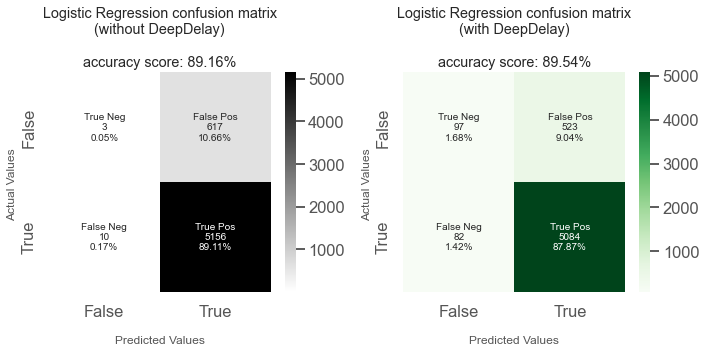

In [164]:
sns.set_context("talk")
plt.style.use('ggplot')
fig,axes = plt.subplots(1,2, figsize=(10,5))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cf_matrix_wd.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cf_matrix_wd.flatten()/np.sum(cf_matrix_wd)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix_wd, annot=labels, fmt='', cmap='binary',ax=axes[0])
axes[0].set_title('Logistic Regression confusion matrix\n (without DeepDelay) \n\n'+ "accuracy score: {0:.2%}".format(acu_wd));
axes[0].set_xlabel('\nPredicted Values')
axes[0].set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
axes[0].xaxis.set_ticklabels(['False','True'])
axes[0].yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.

# mod1 = logistic regresion unblance classes
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix1.flatten()/np.sum(cf_matrix1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix1, annot=labels, fmt='', cmap='Greens',ax=axes[1])
axes[1].set_title('Logistic Regression confusion matrix\n (with DeepDelay) \n\n' + "accuracy score: {0:.2%}".format(acu1));
axes[1].set_xlabel('\nPredicted Values')
axes[1].set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
axes[1].xaxis.set_ticklabels(['False','True'])
axes[1].yaxis.set_ticklabels(['False','True'])

plt.tight_layout()

plt.show()

$~$

+ **KNN models**: wihtout DeepDelay.

$~$

In [159]:
#with unbalanced classes

X_train_kwd, X_test_kwd, y_train_kwd, y_test_kwd = train_test_split(
    X, y, stratify=y, test_size=0.30, random_state=42)

mod_kwd = KNeighborsClassifier()
mod_kwd.fit(X_train_kwd,y_train_kwd)
y_pred_kwd = mod_kwd.predict(X_test_kwd)



In [160]:
#keep scrore
report_kwd = classification_report(y_test_kwd, y_pred_kwd,output_dict=True)
df_kwd = pd.DataFrame(report_kwd).transpose()
df_kwd= df_kwd.rename("KNN without deepDeleay): " '{}'.format)

#keep confusion matrix
cf_matrix_kwd = confusion_matrix(y_test_kwd, y_pred_kwd)
#keep acurracy
acu_kwd = accuracy_score(y_test_kwd, y_pred_kwd)
#keep AUC
auckwd = roc_auc_score(y_test_kwd, y_pred_kwd)

+ Accuracy and AUC:

In [161]:
print('Accuracy KNN model without "DepDelay":',
      round(acu_kwd , 4)*100, '%')

print('Accuracy KNN model with "DepDelay":',
      round(acu4, 4)*100, '%')

print('AUC KNN model without "DepDelay":',
      round(auckwd, 4)*100, '%')

print('AUC KNN model with "DepDelay":',
      round(auc4, 4)*100, '%')

Accuracy KNN model without "DepDelay": 88.09 %
Accuracy KNN model with "DepDelay": 89.28 %
AUC KNN model without "DepDelay": 51.11 %
AUC KNN model with "DepDelay": 50.0 %


+ classification_report:

In [162]:
#classification_report KNN model without "DepDelay"

df_kwd

,precision,recall,f1-score,support
KNN without deepDeleay): 0,0.210084,0.040323,0.067659,620.000000
KNN without deepDeleay): 1,0.895006,0.981804,0.936398,5166.000000
KNN without deepDeleay): accuracy,0.880919,0.880919,0.880919,0.880919
KNN without deepDeleay): macro avg,0.552545,0.511063,0.502029,5786.000000
KNN without deepDeleay): weighted avg,0.821613,0.880919,0.843308,5786.000000


In [163]:
#classification_report KNN model with "DepDelay"

df4


,precision,recall,f1-score,support
SVC (with unbalanced): 0,0.000000,0.000000,0.000000,620.000000
SVC (with unbalanced): 1,0.892845,1.000000,0.943389,5166.000000
SVC (with unbalanced): accuracy,0.892845,0.892845,0.892845,0.892845
SVC (with unbalanced): macro avg,0.446422,0.500000,0.471695,5786.000000
SVC (with unbalanced): weighted avg,0.797172,0.892845,0.842300,5786.000000


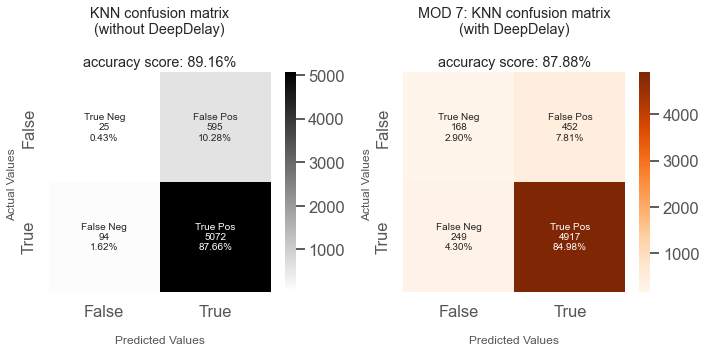

In [167]:
sns.set_context("talk")
plt.style.use('ggplot')
fig,axes = plt.subplots(1,2, figsize=(10,5))


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cf_matrix_kwd.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cf_matrix_kwd.flatten()/np.sum(cf_matrix_kwd)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix_kwd, annot=labels, fmt='', cmap='binary',ax=axes[0])
axes[0].set_title('KNN confusion matrix\n (without DeepDelay) \n\n'+ "accuracy score: {0:.2%}".format(acu_wd));
axes[0].set_xlabel('\nPredicted Values')
axes[0].set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
axes[0].xaxis.set_ticklabels(['False','True'])
axes[0].yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix7.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix7.flatten()/np.sum(cf_matrix7)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix7, annot=labels, fmt='', cmap='Oranges',ax=axes[1])
axes[1].set_title('MOD 7: KNN confusion matrix\n (with DeepDelay) \n\n' + "accuracy score: {0:.2%}".format(acu7));
axes[1].set_xlabel('\nPredicted Values')
axes[1].set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
axes[1].xaxis.set_ticklabels(['False','True'])
axes[1].yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.


plt.tight_layout()

plt.show()


$~$

When we remove the DepDelay variable, the results of our models get worse. This can be verified by comparing the values of the different metrics that we have been working on. Thus, for example, we obtain lower values of Accuracy, AUC, True-Negative, and recall for those models that do not have the DepDelay variable. This tells us that this variable is important when classifying whether or not a flight is late.

$~$

$~$
___
####  Conclusions

$~$

+ To measure the performance of a classification model, especially when there are unbalanced classes, **accuracy** is not a good metric to evaluate our models. Given **unbalanced classes**, the model predicts the majority class, but not the minority class. Hence, although we have high accuracy values, we cannot evaluate our model with this metric since, in this case, the high accuracy values are due solely to the predictions of the majority class.

+ In this sense, as an alternative we can use the value of **Area Under the Curve (AUC)** to measure the performance of the classification models. In the previous examples we have seen that this value gives us a better approximation of the quality of our models.

+ Similarly, the **confusion matrix** is an alternative to evaluate the models. For this exercise (where the minority class was the flights that arrived on time and which we define as 0) we are interested in seeing the values of **True-negatives**, that is, the flights that arrived on time and that the model predicted well.

+ In addition, the **classification report** offers us a series of complementary metrics that can help us evaluate our models, as are the values of **f-1**,**precision**, and **recall**

+ Once we have seen the different metrics, of the three algorithms we worked on, the one that offered the best results was **K-Nearest Neighbors classifier (KNC)**.Not only in terms of the metric values but also in terms of the calculation time. This algorithm was much faster than the others.

+ On the other hand, we have verified that regardless of the algorithm we use, we obtain the best results when we balance the classes(**SMOTE and RUS**). This is something important and should be taken into account in when working  with unbalanced classes.

+ To improve the performance of our models, tuning the hyperparameters(Using **grindSearch**) is a good option. In addition to normalizing(Using **RobustScaler**) the data. In both cases, we have improved the results of all models


___
$~$

___
$~$

####  *References*:

+ [Building A Logistic Regression in Python, Step by Step](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8) 
+ [How to Combine Oversampling and Undersampling for Imbalanced Classification](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/) 
+ [sklearn error ValueError: Input contains NaN, infinity or a value too large for dtype('float64')](https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for) 
+  [Evaluating A Classification Model](https://youtu.be/XiUlqN1Ay0U)
+ [How to plot confusion matrix in python](https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/)
$~$
___